In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import imgaug as ia

In [34]:
# df = pd.read_csv("data/training.csv")
df = pd.read_csv('data/resized226_org_train.csv')
df['Image'] = df['Image'].apply(lambda im:np.fromstring(im, sep=' '))

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
left_eye_center_x            2140 non-null float64
left_eye_center_y            2140 non-null float64
right_eye_center_x           2140 non-null float64
right_eye_center_y           2140 non-null float64
left_eye_inner_corner_x      2140 non-null float64
left_eye_inner_corner_y      2140 non-null float64
left_eye_outer_corner_x      2140 non-null float64
left_eye_outer_corner_y      2140 non-null float64
right_eye_inner_corner_x     2140 non-null float64
right_eye_inner_corner_y     2140 non-null float64
right_eye_outer_corner_x     2140 non-null float64
right_eye_outer_corner_y     2140 non-null float64
left_eyebrow_inner_end_x     2140 non-null float64
left_eyebrow_inner_end_y     2140 non-null float64
left_eyebrow_outer_end_x     2140 non-null float64
left_eyebrow_outer_end_y     2140 non-null float64
right_eyebrow_inner_end_x    2140 non-null float64
right_eyebrow_inner_end_y 

In [36]:
df.count()

left_eye_center_x            2140
left_eye_center_y            2140
right_eye_center_x           2140
right_eye_center_y           2140
left_eye_inner_corner_x      2140
left_eye_inner_corner_y      2140
left_eye_outer_corner_x      2140
left_eye_outer_corner_y      2140
right_eye_inner_corner_x     2140
right_eye_inner_corner_y     2140
right_eye_outer_corner_x     2140
right_eye_outer_corner_y     2140
left_eyebrow_inner_end_x     2140
left_eyebrow_inner_end_y     2140
left_eyebrow_outer_end_x     2140
left_eyebrow_outer_end_y     2140
right_eyebrow_inner_end_x    2140
right_eyebrow_inner_end_y    2140
right_eyebrow_outer_end_x    2140
right_eyebrow_outer_end_y    2140
nose_tip_x                   2140
nose_tip_y                   2140
mouth_left_corner_x          2140
mouth_left_corner_y          2140
mouth_right_corner_x         2140
mouth_right_corner_y         2140
mouth_center_top_lip_x       2140
mouth_center_top_lip_y       2140
mouth_center_bottom_lip_x    2140
mouth_center_b

In [37]:
df = df.dropna()

In [38]:
X = np.vstack(df['Image'].values)
X = X.astype(np.float32)

In [40]:
y = df[df.columns[:-1]].values
# X = X.reshape(X.shape[0], 96, 96)
X = X.reshape(X.shape[0], 226, 226)

In [41]:
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage

def get_kps(y_data):
    """
    convert y_data into Keypoint()
    
    param: y_data: annotations set
    """
    kps = []
    for i in range(len(y_data) // 2):
        kps.append(Keypoint(y_data[2 * i], y_data[2 * i + 1]))
    return kps


def arr_to_kps(annotations):
    """
    Applying get_kps() function to all over the y_datas(argname: annotations)
    """
    kpss = []
    for anno in annotations:
        kpss.append(get_kps(anno))
    return kpss


def gray_to_rgb(imgs):
    """
    gray scale image to rgb image
    
    param: imgs: (batch, height, width)
    """
    rgb_imgs = np.zeros((imgs.shape[0], imgs.shape[1], imgs.shape[2], 3))
    for i in range(3):
        rgb_imgs[:, :, :, i] = imgs
    return rgb_imgs.astype('uint8')
        
# test
# kps = get_kps(y[0])
# kpsoi = KeypointsOnImage(kps, shape=X[0].shape)
# X_ = gray_to_rgb(X)
# ia.imshow(kpsoi.draw_on_image(X_[0], size=2))

## Augmentation function

### rotation

Now to the actual augmentation. We want to apply an affine transformation, which will alter both the image and the keypoints. We choose a bit of translation and rotation as our transoformation. Additionally, we add a bit of color jittering to the mix. That color jitter is only going to affect the image, not the keypoints.

In [42]:
import imgaug.augmenters as iaa
ia.seed(3)

seq = iaa.Sequential([
    iaa.Affine(rotate=(-30, 30))
    # iaa.Affine(translate_px={"x":(10, 30)}, rotate=(-10, 10)),
    # iaa.AddToHueAndSaturation((-50, 50))  #color jitter, only affects the image
])

In [43]:
X = gray_to_rgb(X)
y = arr_to_kps(y)
aug_X = []
aug_y = []
for i in range(X.shape[0]):
    aug_img, aug_kpsoi = seq(image=X[i], keypoints=y[i])
    aug_X.append(aug_img)
    aug_y.append(aug_kpsoi)

    

# img = ia.imresize_single_image(img.astype('uint8'), (96, 96))
# img_aug, kpsoi_aug = seq(image=img, keypoints=kpsoi)

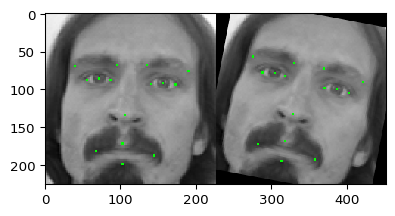

In [44]:
ia.imshow(
    np.hstack([
        # kpsoi.draw_on_image(img, size=2),
        # kpsoi_aug.draw_on_image(img_aug, size=2)
        KeypointsOnImage(y[0], shape=X[0].shape).draw_on_image(X[0], size=2),
        KeypointsOnImage(aug_y[0], shape=aug_X[0].shape).draw_on_image(aug_X[0], size=2)
    ])
)

### Resize into 226
!!! ATTENTION !!!
Don't use with rotate or whatever
RUN ONLY THIS PART if you want to generate 226*226 size images
then re-apply other data augmentation part

If you want to use this code, change these cells modes.

X_ = gray_to_rgb(X)
y_ = arr_to_kps(y)

"""
example code
"""  

kpsoi = KeypointsOnImage(y_[0], shape=X_[0].shape)
image_larger = ia.imresize_single_image(X_[0], 2.0)

print("Small image %s with keypoints optimized for the size:" % (X_[0].shape,))
ia.imshow(kpsoi.draw_on_image(X_[0], size=7))

print("Large image %s with keypoints optimized for the small image size:" % (image_larger.shape,))
ia.imshow(kpsoi.draw_on_image(image_larger, size=7))

print("Large image %s with keypoints projected onto that size:" % (image_larger.shape,))
ia.imshow(kpsoi.on(image_larger).draw_on_image(image_larger, size=7))

"""
real code
"""  
resized_X = []
resized_y = []

for i in range(X_.shape[0]):
    kpsoi = KeypointsOnImage(y_[i], shape=X_[i].shape)
    resized_img = ia.imresize_single_image(X_[i], (226, 226))
    resized_kpsoi = kpsoi.on(resized_img)
    resized_X.append(resized_img)
    resized_y.append(resized_kpsoi)

ia.imshow(resized_X[0])
ia.imshow(resized_y[0].draw_on_image(resized_X[0], size=5))

aug_X = resized_X
aug_y = resized_y

In [45]:
# transformed images to save csv file
new_X = []
for img in aug_X:
    new_X.append(img[:, :, 0])
new_X = np.array(new_X).reshape(np.array(new_X).shape[0], -1)
print(new_X.shape)

(2140, 51076)


# transformed annotations to save csv file
new_y = []
for anno in aug_y:
    new_y.append(KeypointsOnImage(anno, shape=X[0].shape).to_xy_array().reshape(-1))
    # new_y.append(anno.to_xy_array().reshape(-1))  # anno is already KeypointsOnImage
new_y = np.array(new_y)
new_y.shape

In [46]:
columns = []
for col in df.columns:
    columns.append(col)

In [47]:
new_y_df = pd.DataFrame(data=new_y.astype('float64'), columns=columns[:-1])

In [48]:
new_X_df = pd.DataFrame([], columns=['Image'], index=range(len(new_X)))

for i in range(len(new_X)):
    str_ = ""
    for j in range(new_X.shape[1]):
        str_ += "{} ".format(new_X[i, j])
    new_X_df.iloc[i, 0] = str_
    # new_X_df.iloc[i, 0] = np.array2string(new_X[i], separator=' ').replace("[", "").replace("]", "")

In [49]:
# np.fromstring(np.array2string(new_X[0], separator=' ').replace("[", "").replace("]", ""), sep=' ')
new_X_df.head()

,Image
0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 205 234 ...
1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [50]:
new_df = pd.concat([new_y_df, new_X_df], axis=1)
new_df.to_csv('data/resized226_rotate_30.csv', index=False)
# new_df.to_csv('data/resized226_org_train.csv', index=False)

## shifting keypoints

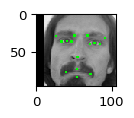

In [59]:
img_pad = ia.pad(img, left=10)
kpsoi_pad = kpsoi.shift(x=10)
ia.imshow(kpsoi_pad.draw_on_image(img_pad, size=2))

In [66]:
arr = kpsoi.to_xy_array()
print(arr.shape)
print(arr)
print(arr.reshape(-1))

(15, 2)
[[66.03356  39.002274]
 [30.227007 36.421677]
 [59.582077 39.647423]
 [73.13035  39.969997]
 [36.35657  37.3894  ]
 [23.452871 37.3894  ]
 [56.953262 29.033648]
 [80.22713  32.228138]
 [40.227608 29.002321]
 [16.356379 29.64747 ]
 [44.42057  57.066803]
 [61.19531  79.97017 ]
 [28.614496 77.38899 ]
 [43.312603 72.935455]
 [43.130707 84.48577 ]]
[66.03356  39.002274 30.227007 36.421677 59.582077 39.647423 73.13035
 39.969997 36.35657  37.3894   23.452871 37.3894   56.953262 29.033648
 80.22713  32.228138 40.227608 29.002321 16.356379 29.64747  44.42057
 57.066803 61.19531  79.97017  28.614496 77.38899  43.312603 72.935455
 43.130707 84.48577 ]
